### Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

### Utility Functions


In [2]:
def bgr_to_rgb(image):
    b,g,r = cv2.split(image)
    return cv2.merge([r,g,b])

def read_image_files(path):
    images = []
    image_files = glob.glob(path)
    for image_file in image_files:
        images.append(bgr_to_rgb(cv2.imread(image_file)))
    return images

#from lessson
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy
def plot_color_histogram(rh, gh, bh, bincen):
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
    plt.show()
    

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

### Data Set Source Globals


In [3]:
test_images = read_image_files('./test_images/*.jpg')
cutout_images = read_image_files('./test_images/cutouts/cutout*.jpg')
color_space_images = read_image_files('./test_images/color_space/*.png')
spatial_images = read_image_files('./test_images/spatial/*.jpg')
vehicle_images = glob.glob('./dataset/vehicles/**/*.png', recursive=True)
non_vehicle_images = glob.glob('./dataset/non-vehicles/**/*.png', recursive=True)

### Inspect Data Set

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


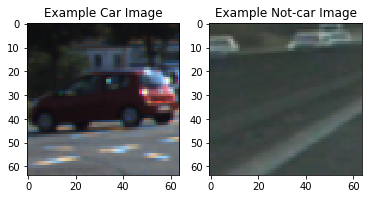

In [4]:
#Adapted from the lesson
data_info = data_look(vehicle_images, non_vehicle_images)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(vehicle_images))
notcar_ind = np.random.randint(0, len(non_vehicle_images))
    
# Read in car / not-car images
car_image = mpimg.imread(vehicle_images[car_ind])
notcar_image = mpimg.imread(non_vehicle_images[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()

### Color Histogram Extraction

In [5]:
#Adapted from the lesson
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

### Test Color Histogram Extraction

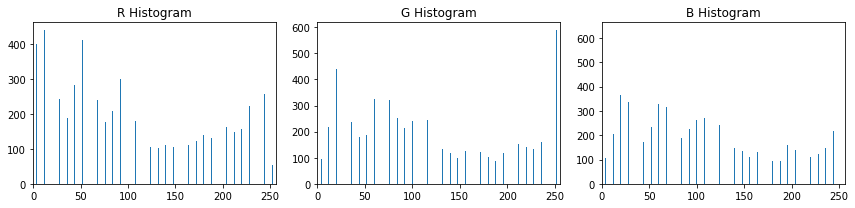

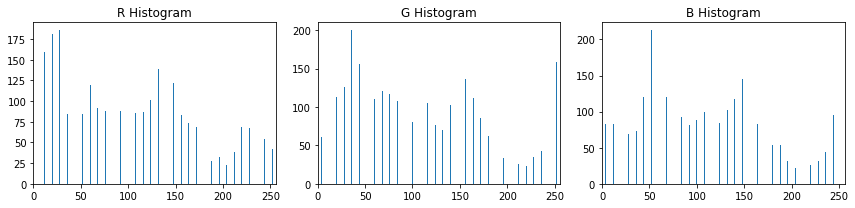

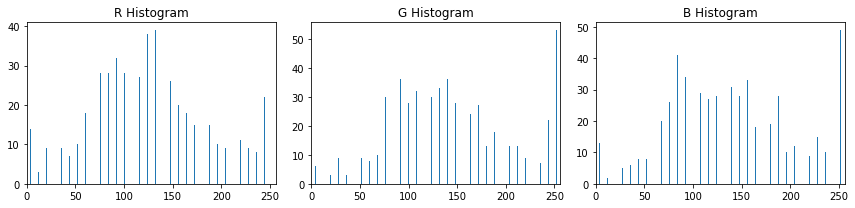

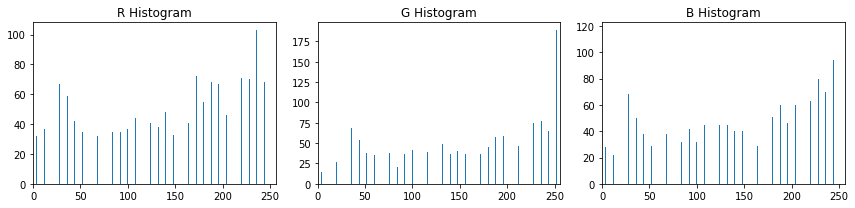

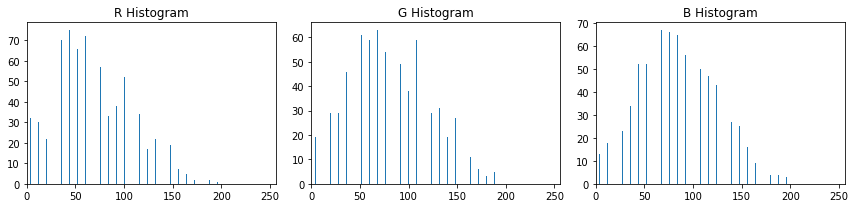

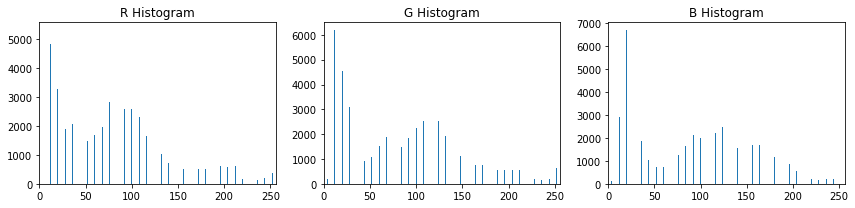

In [6]:

for image in cutout_images:
    rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))
    if rh is not None:
        plot_color_histogram(rh, gh, bh, bincen)
    else:
        print('Your function is returning None for at least one variable...')

### Color Spatial Binning

In [7]:
#Adapted from the lesson
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    return features

### Test Color Spatial Binning

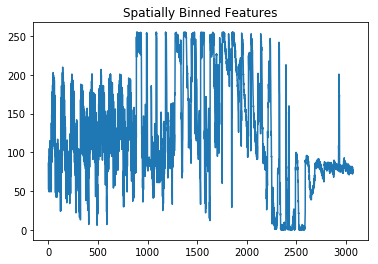

In [8]:
for image in spatial_images:
    feature_vec = bin_spatial(image, color_space='RGB', size=(32, 32))
    # Plot features
    plt.plot(feature_vec)
    plt.title('Spatially Binned Features')
    plt.show()

### Histogram of Gradients

In [9]:
#Adapted from the lesson
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

### Test HOG Feature Extraction

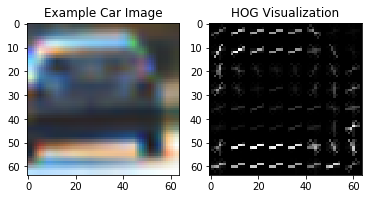

In [10]:
#Adapted from the lesson
# Generate a random index to look at a car image
ind = np.random.randint(0, len(vehicle_images))
# Read in the image
image = mpimg.imread(vehicle_images[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()


### Feature Extraction Function

In [11]:
#Adapted from the lesson
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            rh, gh, bh, bincen, hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Feature Extraction Globals

In [12]:
#Configuration 1
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()
xy_window=(128, 128) 
xy_overlap=(0.5, 0.5)
#Configuration 2
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 800] # Min and max in y to search in slide_window()
x_start_stop = [None, None]
xy_window=(128, 128) 
xy_overlap=(0.5, 0.5)
#Configuration 3LUV
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 800] # Min and max in y to search in slide_window()
x_start_stop = [None, None]
xy_window=(128, 128) 
xy_overlap=(0.5, 0.5)
#Configuration 4
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 800] # Min and max in y to search in slide_window()
x_start_stop = [None, None]
xy_window=(128, 128) 
xy_overlap=(0.5, 0.5)
#Configuration 5
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 800] # Min and max in y to search in slide_window()
x_start_stop = [None, None]
xy_window=(128, 128) 
xy_overlap=(0.5, 0.5)




### Extract Features and Scale Results

75.18 Seconds to extract HOG features...


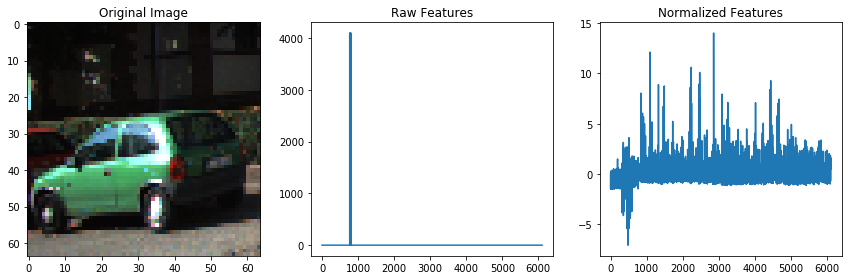

In [13]:

#Adapted from the lesson
t=time.time()
car_features = extract_features(vehicle_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(non_vehicle_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

X_scaler = StandardScaler().fit(X)
# Apply the scaler to X

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(vehicle_images))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(vehicle_images[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()
plt.show()


### Train Classifier


In [14]:
#Adapted from the lesson
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
28.12 Seconds to train SVC...
Test Accuracy of SVC =  0.9862
My SVC predicts:  [ 0.  0.  1.  1.  1.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  1.  1.  1.  1.  0.]
0.00315 Seconds to predict 10 labels with SVC


### Windowing Functions

In [15]:
#Adapted from the lesson
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

### Test Windowing Functions

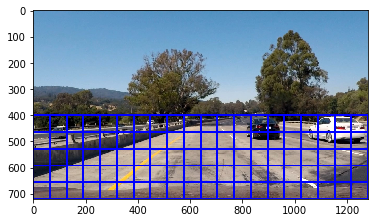

In [16]:
image = test_images[0]

windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=xy_window, xy_overlap=xy_overlap)
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()

### Single Image Feature Extraction

In [17]:
#Adapted from the lesson
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images


def single_img_features(img, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_bins, hog_feat=hog_feat):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        rh, gh, bh, bincen, hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

   #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    return on_windows

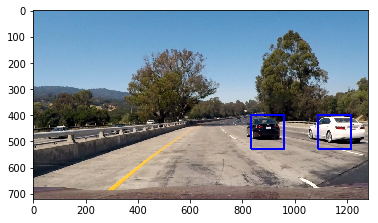

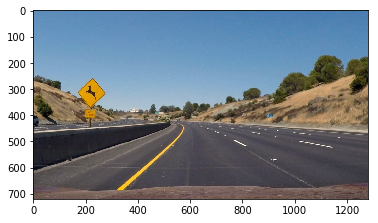

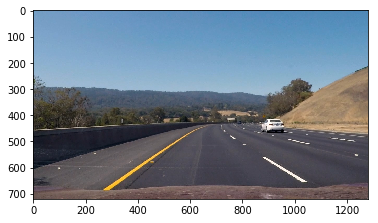

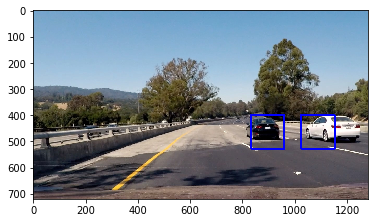

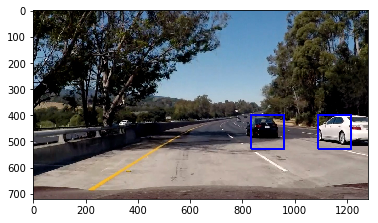

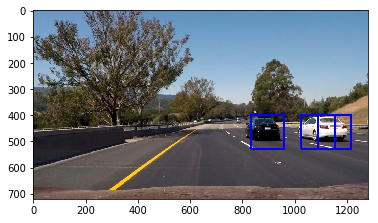

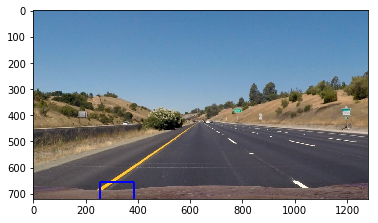

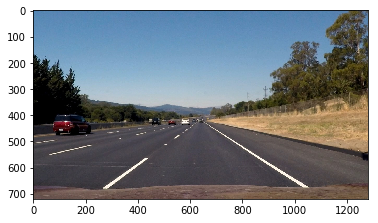

In [18]:
test_image_hot_windows = []
for image in test_images:
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255
    windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                           xy_window=xy_window, xy_overlap=xy_overlap)

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                     
    test_image_hot_windows.append(hot_windows)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    
    plt.imshow(window_img)
    plt.show()

### Heat Map and Label Box Drawing

In [19]:
#Adapted from the lesson
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

0 cars found


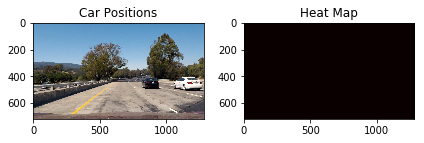

0 cars found


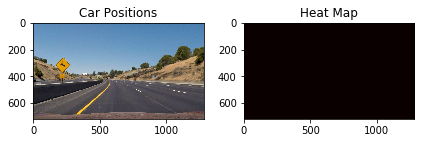

0 cars found


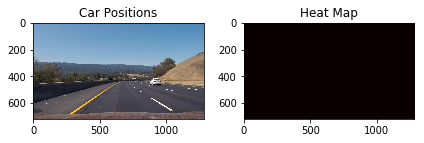

0 cars found


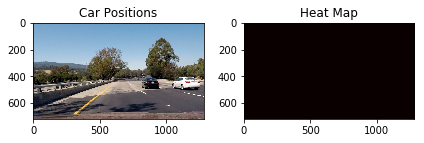

0 cars found


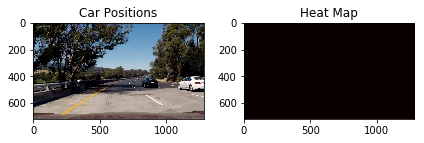

1 cars found


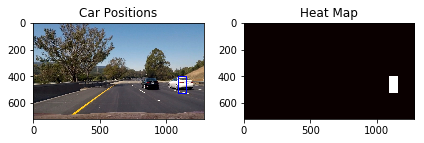

0 cars found


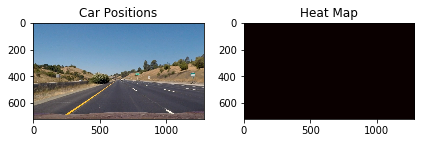

0 cars found


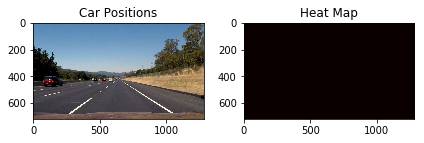

In [20]:
for i, image in enumerate(test_images):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,test_image_hot_windows[i])
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    print(labels[1], 'cars found')
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.show()

In [21]:
#Adapted from the lesson
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    rectangles = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
  
     
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
        
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    #nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    #nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nxblocks = (ch1.shape[1] // pix_per_cell)  + 1
    nyblocks = (ch1.shape[0] // pix_per_cell)  + 1
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    #nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
        
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
                
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            
            spatial_features = bin_spatial(subimg, size=spatial_size)
            rh, gh, bh, bincen, hist_features = color_hist(subimg, nbins=hist_bins)
            
       
            # Scale features and make a prediction
            test_stack = np.hstack((spatial_features, hist_features, hog_features))
       
            test_features = X_scaler.transform(test_stack.reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                           
    return rectangles

In [22]:
# %load find_lanes.py
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip




def bgr_to_rgb(image):
    b,g,r = cv2.split(image)
    return cv2.merge([r,g,b])

def compare_three_images(image1, image2, image3, cmap=None):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 9))
    f.tight_layout()
    ax1.imshow(image1, cmap=cmap)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(image2, cmap=cmap)
    ax2.set_title('Processed Image', fontsize=20)
    ax3.imshow(image3, cmap=cmap)
    ax3.set_title('Processed Image', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    
def compare_images(image1, image2, cmap=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
    f.tight_layout()
    ax1.imshow(image1, cmap=cmap)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(image2, cmap=cmap)
    ax2.set_title('Processed Image', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

def compare_first_stage_images(image1, image2, cmap=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
    f.tight_layout()
    ax1.imshow(image1, cmap=cmap)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(image2, cmap='gray')
    ax2.set_title('Processed Image', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
def compare_prospective_images(image1, image2, src, dst, cmap=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1, cmap=cmap)
    ax1.plot(src[0][0], src[0][1], '.')
    ax1.plot(src[1][0], src[1][1], '.')
    ax1.plot(src[2][0], src[2][1], '.')
    ax1.plot(src[3][0], src[3][1], '.')
    ax1.axvline(x=dst[0][0])
    ax1.axvline(x=dst[2][0])  
    ax1.plot(dst[0][0], dst[0][1], 'x')
    ax1.plot(dst[1][0], dst[1][1], 'x')
    ax1.plot(dst[2][0], dst[2][1], 'x')
    ax1.plot(dst[3][0], dst[3][1], 'x')
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(image2, cmap=cmap)
    ax2.plot(src[0][0], src[0][1], '.')
    ax2.plot(src[1][0], src[1][1], '.')
    ax2.plot(src[2][0], src[2][1], '.')
    ax2.plot(src[3][0], src[3][1], '.')
    ax2.axvline(x=dst[0][0])
    ax2.axvline(x=dst[2][0])
    ax2.plot(dst[0][0], dst[0][1], 'x')
    ax2.plot(dst[1][0], dst[1][1], 'x')
    ax2.plot(dst[2][0], dst[2][1], 'x')
    ax2.plot(dst[3][0], dst[3][1], 'x')
    ax2.set_title('Processed Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

def plot_lane_histogram(image):
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    plt.plot(histogram)
    plt.show()

def compare_final_out(image1, image2, left_fitx, right_fitx, ploty):  
    plt.imshow(image1)
    plt.show()
    plt.imshow(image2)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()
    
def read_image_files(path):
    images = []
    image_files = glob.glob(path)
    #add some error checking
    for image_file in image_files:
        images.append(bgr_to_rgb(cv2.imread(image_file)))
    return images

def trap_area(deminsions):
    bt1 = np.float32(deminsions[0][0])
    bt2 = np.float32(deminsions[3][0])
    bb1 = np.float32(deminsions[1][0])
    bb2 = np.float32(deminsions[2][0])
    h1 = np.float32(deminsions[0][1])
    h2 = np.float32(deminsions[1][1])
    baset = abs(bt1-bt2)
    baseb = abs(bb1-bb2)
    height = abs(h1-h2)
    return ((baset + baseb)/2.0)*height +29

def rec_deminsions(rec_deminsions, trap_area):
    new_demin = np.copy(rec_deminsions)
    new_demin[0][0] = rec_deminsions[1][0]
    new_demin[3][0] = rec_deminsions[2][0]
    sq_width = abs(rec_deminsions[1][0] - rec_deminsions[2][0])
    sq_height = trap_area/sq_width
    new_demin[0][1] = int(new_demin[0][1] - sq_height)
    new_demin[3][1] = int(new_demin[3][1] - sq_height)
    return new_demin


def calibrate_camera(nx=9, ny=6):
    objpoints = [] #3D points in real world space
    imgpoints = [] #2D points in image plane
    # Prepare object points like (0,0,0, (1,0,0), (2,0,0)....,(7,4,0)
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    images = calibration_images
          
    gray_image = cv2.cvtColor(images[0], cv2.COLOR_BGR2GRAY)
    gray_shape = gray_image.shape[::-1]

    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
        else:
            print("Error detecting corners in image %s. Exiting" % image_file)
            ret = False
    return cv2.calibrateCamera(objpoints, imgpoints, gray_shape, None, None)

def undistort_image(image, mtx, dist):
    return cv2.undistort(image, mtx, dist, None, mtx)


def abs_sobel_thresh(image, orient='x', thresh=(0,255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    else:
        print("bad orient passed")
        exit()
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sbinary


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output



def color_hls_threshold(image, channel='h', thresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    if channel == 'h':
        convert_channel = H
    elif channel == 'l':
        convert_channel = L
    elif channel == 's':
        convert_channel = S
    else:
        print("bad channel")
        exit()
    binary = np.zeros_like(convert_channel)
    binary[(convert_channel > thresh[0]) & (convert_channel <= thresh[1])] = 1
    return binary

def color_rgb_threshold(image, channel='r', thresh=(0,255)):
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    if channel == 'r':
        convert_channel = R
    elif channel == 'G':
        convert_channel = G
    elif channel == 'b':
        convert_channel = b
    else:
        print("bad channel")
        exit()
    binary = np.zeros_like(convert_channel)
    binary[(convert_channel > thresh[0]) & (convert_channel <= thresh[1])] = 1
    return binary


def prospective_transform(image, src, dst):
    img_size = (image.shape[1], image.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return warped


def first_stage_pipeline(image, mtx, dist, src, dst, area):
    new_image = cv2.undistort(image, mtx, dist, None, mtx)
    xsobel = abs_sobel_thresh(new_image,'x', (20, 100))
    ysobel = abs_sobel_thresh(new_image,'y', (20, 100))
    magthresh =  mag_thresh(new_image,3, (30, 100))
    dirthresh = dir_threshold(new_image, sobel_kernel=15, thresh=(0.7, 1.3))
    
    combined = np.zeros_like(dirthresh)
    combined[((xsobel == 1) & (ysobel == 1)) | ((magthresh == 1) & (dirthresh == 1))] = 1
    
    r =  color_rgb_threshold(new_image, channel='r', thresh=(200,255))
    s =  color_hls_threshold(new_image, channel='s', thresh=(90,200))
    
    color_combined =np.zeros_like(r)
    color_combined[(r == 1) & (s == 1)] = 1
    
    combined_binary = np.zeros_like(color_combined)
    combined_binary[(color_combined == 1) | (combined == 1)] = 1
    combined_binary = prospective_transform(combined_binary, src, dst)
    return combined_binary

def find_line_fits(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    left_lane_center = []
    right_lane_center = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            left_lane_center.append(leftx_current) 
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            right_lane_center.append(rightx_current)
            

                # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
      
    return out_img, left_fitx, right_fitx, ploty, left_lane_center, right_lane_center

def find_distance_from_center(image, left_center, right_center):
    x_width = image.shape[1]
    camera_center = x_width/2
    left_lane_location = left_center[0]
    right_lane_location = right_center[0]
    lane_center = (right_lane_location - left_lane_location)/2 + left_lane_location
    #conversion of pixels per meter = 3.7/700
    num_pixel_off_center = abs(lane_center - camera_center) * (3.7/700)
    return num_pixel_off_center

def radius_of_curve(ploty, leftx, rightx):
    
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad

def project_results(image, warped, ploty, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    M = cv2.getPerspectiveTransform(dst, src)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M, (image.shape[1], image.shape[0])) 
    #newwarp = prospective_transform(color_warp, dst, src)
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result


def second_stage_pipeline(image, pipe_image, left_fitx, right_fitx, ploty, left_center, right_center):
    distance_off_center = find_distance_from_center(pipe_image, left_center, right_center)
    left_radius, right_radius = radius_of_curve(ploty,left_fitx,right_fitx)
    new_image = project_results(image, pipe_image, ploty, left_fitx, right_fitx)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(new_image,'Offset: %f m' %(distance_off_center) ,(10,100), font, 1,(255,255,255),2)
    cv2.putText(new_image,'L Curve: %.2f m' %(left_radius) ,(10,150), font, 1,(255,255,255),2)
    cv2.putText(new_image,'R Curve: %.2f m' %(right_radius) ,(10,200), font, 1,(255,255,255),2)
    return new_image


calibration_images = read_image_files('./camera_cal/calibration*.jpg')
test_images = read_image_files('./test_images/*.jpg')

src = np.float32([[716, 470],
                  [1009, 660],
                  [288, 660],
                  [567, 470]])

area = trap_area(src)
dst = rec_deminsions(src, area)

ret, mtx, dist, rvecs, tvecs = calibrate_camera(9, 6)


def process_lane_lines(image):
    new_image = first_stage_pipeline(image, mtx, dist, src, dst, area)
    binary_warped, left_fitx, right_fitx, ploty, left_center, right_center = find_line_fits(new_image)
    return second_stage_pipeline(image, new_image,left_fitx, right_fitx, ploty, left_center, right_center)


    


In [23]:
def process_frame(test_img):
    
    test_img = process_lane_lines(test_img)
    rects = []
    #ystart = 368
    #ystop = 432
    #scale = 0.5
    #rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
    #                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False))
    ystart = 400
    ystop = 464
    scale = 1.0
    rects.append(find_cars(test_img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False))
    ystart = 416
    ystop = 480
    scale = 1.0
    rects.append(find_cars(test_img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False))
    ystart = 400
    ystop = 496
    scale = 1.5
    rects.append(find_cars(test_img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False))
    ystart = 432
    ystop = 528
    scale = 1.5
    rects.append(find_cars(test_img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False))
    ystart = 400
    ystop = 528
    scale = 2.0
    rects.append(find_cars(test_img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False))
    ystart = 432
    ystop = 560
    scale = 2.0
    rects.append(find_cars(test_img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False))
    ystart = 400
    ystop = 596
    scale = 3.5
    rects.append(find_cars(test_img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False))
    ystart = 464
    ystop = 660
    scale = 3.5
    rects.append(find_cars(test_img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False))
    
    
    rectangles = [item for sublist in rects for item in sublist] 
    
    heatmap_img = np.zeros_like(test_img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img,2)
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
    return draw_img

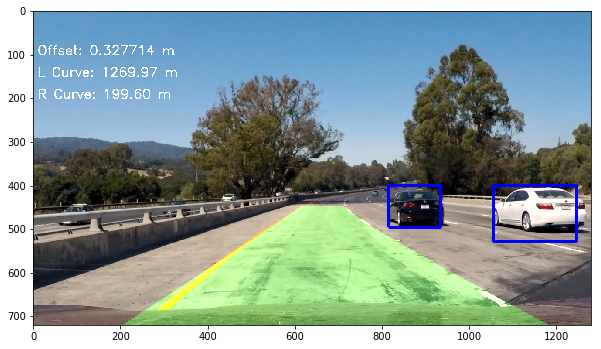

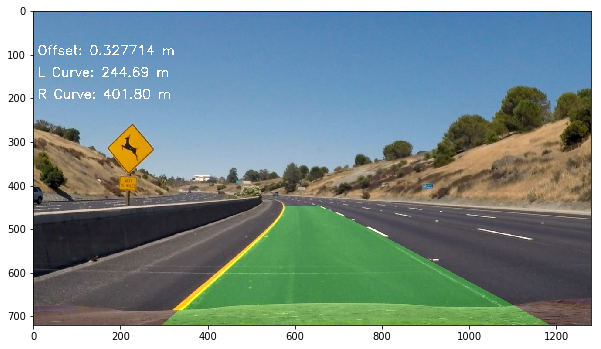

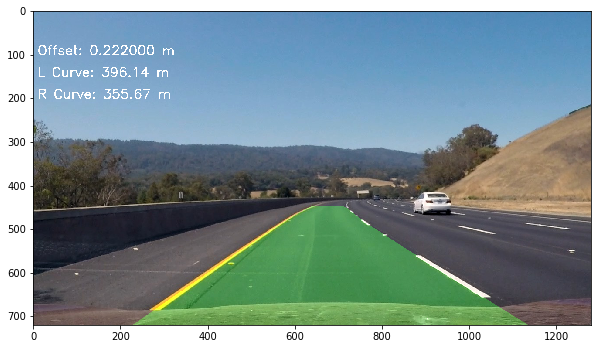

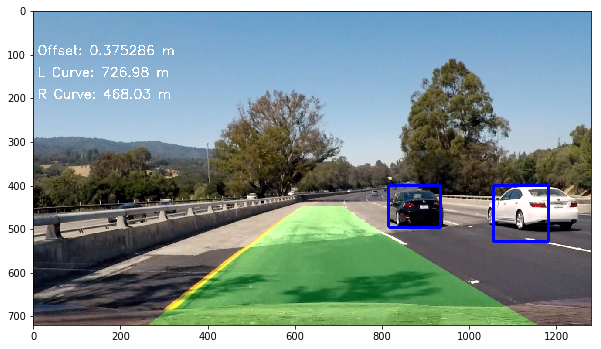

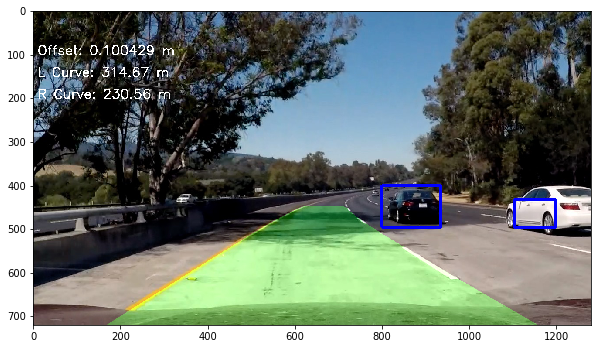

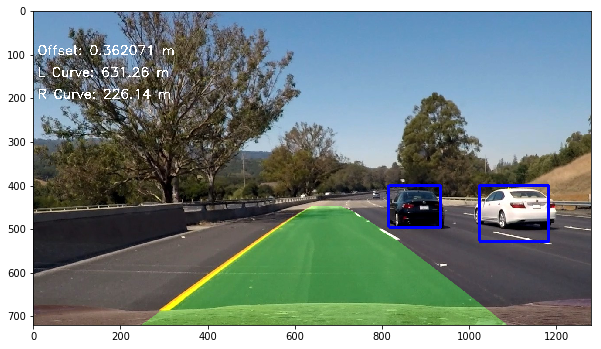

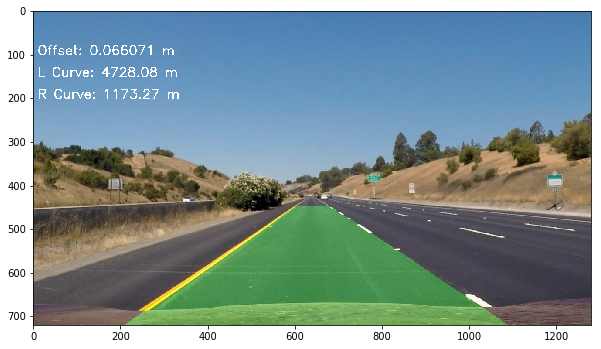

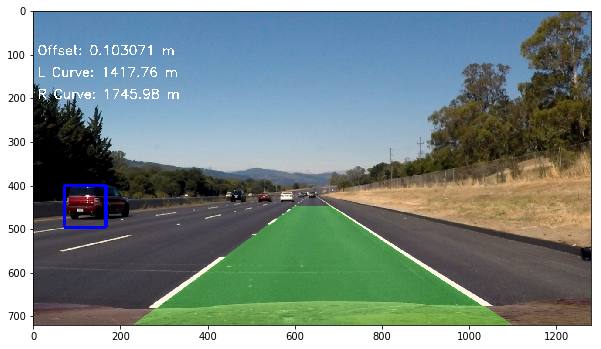

In [24]:
for test_img in test_images:
    draw_img = process_frame(test_img)
    plt.figure(figsize=(10,10))
    plt.imshow(draw_img)
    plt.show()


In [25]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:26<00:00,  1.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 47.4 s, sys: 332 ms, total: 47.7 s
Wall time: 27.3 s


In [26]:
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)


[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [14:31<00:00,  1.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 26min 11s, sys: 2.53 s, total: 26min 14s
Wall time: 14min 32s
